<a href="https://colab.research.google.com/github/subminu/Recurrence-Neural-Network-from-scratch/blob/main/Recurrent_Neural_Network_from_scratch_with_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network from scratch with python

## 0. Import dependency pacakge

In [ ]:
!pip install emoji

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from drive.MyDrive.RNN_scratch.data_train_test import emo_utils

## 1. Load data

In [ ]:
google_drive_dir = "./drive/MyDrive/RNN_scratch/"
X_t, Y_t = emo_utils.read_csv(google_drive_dir + "data_train_test/train_emoji.csv")
X_r, Y_r = emo_utils.read_csv(google_drive_dir + "data_train_test/test_emoji.csv")

In [ ]:
print(X_t[2], type(Y_t[0]))

It is the worst day in my life <class 'numpy.int64'>


In [ ]:
words_to_index_50d, index_to_words_50d, word_to_vec_map_50d = emo_utils.read_glove_vecs(google_drive_dir+"word_embadding/glove.6B.50d.txt")
words_to_index_100d, index_to_words_100d, word_to_vec_map_100d = emo_utils.read_glove_vecs(google_drive_dir+"word_embadding/glove.6B.100d.txt")

## 2. Optimizer

### 2.1 Stochastic Gradient Descent

In [ ]:
class SGD:
  def __init__(self, learning_rate=1e-2):
    self.lr = learning_rate

  def __call__(self, X, dX):
    X -= self.lr * dX
    return X
  
  def flush(self):
    pass

### 2.2 Adam

In [ ]:
class Adam:
  def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
    self.lr = learning_rate
    self.b1 = beta_1
    self.b2 = beta_2
    self.e = epsilon

    self.M = 0
    self.V = 0
    self.t = 0

  def __call__(self, X, dX):
    self.t += 1
    
    self.M = self.b1 * self.M + (1 - self.b1) * dX
    self.V = self.b2 * self.V + (1 - self.b2) * (dX * dX)

    M_cap = self.M / (1 - (self.b1**self.t))
    V_cap = self.V / (1 - (self.b2**self.t))

    X -= self.lr * (M_cap / np.sqrt(V_cap+self.e))

    return X
  
  def flush(self):
    self.M = 0
    self.V = 0
    self.t = 0

## 3. Activation function

### 3.1 ReLU

In [ ]:
class ReLU:
    def prop(self, X):
        return np.maximum(0, X)
    
    def derivative(self, X):
        result = np.copy(X)
        result[result >= 0] = 1
        result[result < 0] = 0
        return result

### 3.2 Hyperbolic tangent

In [ ]:
class Tanh:
  def __init__(self):
    self.out = None
    pass

  def __call__(self, X):
    self.out = np.tanh(X)
    return self.out

### 3.3 Sigmoid

In [ ]:
class Sigmoid:
  def __init__(self):
    self.out = None
    pass

  def __call__(self, X):
    self.out = 1 / (1 + np.exp(-1 * X))
    return self.out

### 3.4 Softmax

In [ ]:
class Softmax:
    def __init__(self):
        self.output = None
    
    def prop(self, X):
        X -= np.max(X, axis=1, keepdims=True)
        self.output = np.exp(X)/np.sum(np.exp(X), axis=1, keepdims=True)
        return self.output
    
    def derivative(self, Y):
        """This function was used for derivative loss_func(softmax(Y_hat),Y)"""
        result = self.output.copy()
        result[np.arange(result.shape[0]),Y] -= 1
        return result

## 4. Layers

### 4.1 Layer_embadding

In [ ]:
class Layer_embadding:
  def __init__(self, glove):
    """
      glove - we used already trained embadding word to vector map.
    """
    self.word_to_vec = glove
    pass

  def prop(self, X, train_mode=True):
    return np.array([self.word_to_vec[x.lower()].reshape(1,-1) for x in X.split()])

  def backprop(self, dZ):
    pass

  def update(self):
    pass
  
  def flush(self, flush_opt=False):
    pass

### 4.2 Layer_dropout

In [ ]:
class Layer_dropout:
  def __init__(self, threshold):
    self.threshold = threshold
    self.mask = None
    pass

  def prop(self, X, train_mode=True):
    if train_mode:
      self.mask = np.random.rand(*X.shape) > self.threshold
      return np.multiply(X, self.mask)
    else:
      return X * self.threshold

  def backprop(self, dZ):
    return np.multiply(dZ, self.mask)

  def update(self):
    pass

  def flush(self, flush_opt=False):
    pass

### 4.3 Layer_dense

In [ ]:
class Layer_dense:
  def __init__(self, input_size, output_size, activation, optimizer, output_layer=False):
      # parameters
      self.W = np.random.normal(size=(input_size, output_size))
      self.b = np.random.normal(size=(1,output_size))

      # parameters(derivative)
      self.dW = None
      self.db = None

      # history
      self.inputs = None
      self.L = None

      # activation
      self.activation_func = activation()

      # flag
      self.output_layer = output_layer

      # optimizer
      self.opts = { key:optimizer() for key in ["W", "b"] }
  
  def prop(self, X, train_mode=True):
      self.inputs = X
      self.L = np.dot(X, self.W) + self.b
      self.outputs = self.activation_func.prop(self.L) 
      return self.outputs
  
  def backprop(self, dZ):
      if self.output_layer:
          dZ = self.activation_func.derivative(dZ)
      else:
          dZ = np.multiply(self.activation_func.derivative(self.L), dZ)
      
      self.dW = np.dot(self.inputs.T, dZ)
      self.db = np.sum(dZ, axis=0, keepdims = True)

      return np.dot(dZ, self.W.T)
  
  def update(self):
      self.W = self.opts["W"](self.W, self.dW)
      self.b = self.opts["b"](self.b, self.db)

  def flush(self, flush_opt=False):
    if flush_opt:
      for opt in self.opts.values():
        opt.flush()

### 4.4 Layer_vanillaRNN

In [ ]:
class Layer_vanillaRNN:
  def __init__(self, in_dim, hidden_dim, optimizer):
    I, H = in_dim, hidden_dim
    self.W_hh = np.random.normal(size=(H, H), scale=0.05)
    self.W_xh = np.random.normal(size=(I, H), scale=0.05)
    self.b_h = np.zeros((1, H))

    self.dW_hh = 0
    self.dW_xh = 0
    self.db_h = 0

    self.hiddens = [np.zeros((1, H))]
    self.vecs = [None]
    self.N = None

    self.act = Tanh()
    self.opts = { key: optimizer() for key in ["W_hh", "W_xh", "b_h"] }
    pass

  def prop(self, X, train_mode=True):

    self.hiddens = [self.hiddens[0]]
    self.vecs = [None]
    self.N = None

    for t, vec in enumerate(X,1):
      self.vecs.append(vec)

      result = np.dot(self.hiddens[t-1], self.W_hh) + np.dot(self.vecs[t], self.W_xh) + self.b_h
      hidden_next = self.act(result)
      self.hiddens.append(hidden_next)
    
    self.N = t
    return np.array(self.hiddens[1:])

  def backprop(self, dhiddens):
    dH = 0
    dx = []

    self.dW_hh = 0
    self.dW_xh = 0
    self.db_h = 0

    if dhiddens.shape[0] != self.N:
      dhiddens = [dhiddens] + [0 for _ in range(self.N-1)]
    
    for t, dhidden in zip(range(self.N,0,-1), dhiddens):
      dH = dH + dhidden
      dt = dH * (1 - self.hiddens[t]**2)
      # dt = self.act.backprop(dH)


      self.db_h += dt
      self.dW_xh += np.dot(self.vecs[t].T, dt)
      self.dW_hh += np.dot(self.hiddens[t-1].T, dt)

      dx.append(np.dot(dt, self.W_xh.T))
      
      dH = np.dot(dt, self.W_hh.T)
    
    for d in [self.dW_xh, self.dW_hh, self.db_h]:
      np.clip(d, -1, 1, out=d)

    return np.array(dx).reshape(self.N,1,-1)

  def update(self):
    self.W_hh = self.opts["W_hh"](self.W_hh, self.dW_hh)
    self.W_xh = self.opts["W_xh"](self.W_xh, self.dW_xh)
    self.b_h = self.opts["b_h"](self.b_h, self.db_h)
  
  def flush(self):
    for opt in self.opts.values():
      opt.flush()



### 4.5 Layer_LSTM

In [ ]:
class Layer_LSTM:
  def __init__(self, in_dim, hidden_dim, optimizer):
    I, H = in_dim, hidden_dim
    # forget
    self.W_hf = np.random.normal(size=(H, H), scale=0.05)
    self.W_xf = np.random.normal(size=(I, H), scale=0.05)
    self.b_f = np.zeros((1, H))

    # input
    self.W_his = np.random.normal(size=(H, H), scale=0.05)
    self.W_xis = np.random.normal(size=(I, H), scale=0.05)
    self.b_is = np.zeros((1, H))

    self.W_hit = np.random.normal(size=(H, H), scale=0.05)
    self.W_xit = np.random.normal(size=(I, H), scale=0.05)
    self.b_it = np.zeros((1, H))

    # output
    self.W_ho = np.random.normal(size=(H, H), scale=0.05)
    self.W_xo = np.random.normal(size=(I, H), scale=0.05)
    self.b_o = np.zeros((1, H))

    # forget_grad
    self.dW_hf = 0
    self.dW_xf = 0
    self.db_f = 0

    # input_grad
    self.dW_his = 0
    self.dW_xis = 0
    self.db_is = 0

    self.dW_hit = 0
    self.dW_xit = 0
    self.db_it = 0

    # output_grad
    self.dW_ho = 0
    self.dW_xo = 0
    self.db_o = 0

    self.hiddens = [np.zeros((1, H))]
    self.cells = [np.zeros((1, H))]
    self.vecs = [None]

    self.forget_masks = []
    self.input_masks = []
    self.input_infos = []
    self.output_masks = []
    self.output_infos = []

    self.forget_sig = Sigmoid()
    self.input_sig = Sigmoid()
    self.input_tanh = Tanh()
    self.output_sig = Sigmoid()
    self.output_tanh = Tanh()

    self.N = None
    self.opts = { key: optimizer() for key in ["W_hf", "W_xf", "b_f", "W_his", "W_xis", "b_is", "W_hit", "W_xit", "b_it", "W_ho", "W_xo", "b_o"] }

  def prop(self, X, train_mode=True):
    self.hiddens = [self.hiddens[0]]
    self.cells = [self.cells[0]]
    self.vecs = [None]

    self.forget_masks = [None]
    self.input_masks =[None]
    self.input_infos = [None]
    self.output_masks = [None]
    self.output_infos = [None]
    
    for t, vec in enumerate(X,1):
      self.vecs.append(vec)

      # forget
      forget_term = np.dot(self.hiddens[t-1], self.W_hf) + np.dot(vec, self.W_xf) + self.b_f
      forget_mask = self.forget_sig(forget_term)
      cell_next = np.multiply(self.cells[t-1], forget_mask)

      self.forget_masks.append(forget_mask)

      # input
      input_term_1 = np.dot(self.hiddens[t-1], self.W_his) + np.dot(vec, self.W_xis) + self.b_is
      input_term_2 = np.dot(self.hiddens[t-1], self.W_hit) + np.dot(vec, self.W_xit) + self.b_it

      input_mask = self.input_sig(input_term_1)
      input_info = self.input_tanh(input_term_2)

      curr_cell = np.multiply(input_mask, input_info)
      cell_next = cell_next + curr_cell

      self.input_masks.append(input_mask)
      self.input_infos.append(input_info)

      # output
      output_term = np.dot(self.hiddens[t-1], self.W_ho) + np.dot(vec, self.W_xo) + self.b_o

      output_mask = self.output_sig(output_term)
      output_info = self.output_tanh(cell_next)

      hidden_next = np.multiply(output_mask, output_info)

      self.output_masks.append(output_mask)
      self.output_infos.append(output_info)
  
      self.cells.append(cell_next)
      self.hiddens.append(hidden_next)
    
    self.N = t

    return np.array(self.hiddens[1:])

  def backprop(self, dhiddens):
    dH = 0
    dC = 0
    dx = []

    # forget_grad
    self.dW_hf = 0
    self.dW_xf = 0
    self.db_f = 0

    # input_grad
    self.dW_his = 0
    self.dW_xis = 0
    self.db_is = 0

    self.dW_hit = 0
    self.dW_xit = 0
    self.db_it = 0

    # output_grad
    self.dW_ho = 0
    self.dW_xo = 0
    self.db_o = 0

    if dhiddens.shape[0] != self.N:
      dhiddens = [dhiddens] + [0 for _ in range(self.N-1)]
    
    for t, dhidden in zip(range(self.N,0,-1), dhiddens):
      dH = dH + dhidden
      dC = dC + np.multiply(self.output_masks[t], dH) * (1 - self.output_infos[t]**2)

      dom = np.multiply(dH, self.output_infos[t])
      dim = np.multiply(dC, self.input_infos[t])
      dii = np.multiply(dC, self.input_masks[t])
      dfm = np.multiply(dC, self.cells[t-1])

      dom *= self.output_masks[t] * (1 - self.output_masks[t])
      dim *= self.input_masks[t] * (1 - self.input_masks[t])
      dii *= (1 - self.input_infos[t] ** 2)
      dfm *= self.forget_masks[t] * (1 - self.forget_masks[t])
      
      # forget_grad
      self.dW_hf += np.dot(self.hiddens[t-1].T, dfm)
      self.dW_xf += np.dot(self.vecs[t].T, dfm)
      self.db_f += dfm

      # input_grad
      self.dW_his += np.dot(self.hiddens[t-1].T, dim)
      self.dW_xis += np.dot(self.vecs[t].T, dim)
      self.db_is += dii

      self.dW_hit += np.dot(self.hiddens[t-1].T, dii)
      self.dW_xit += np.dot(self.vecs[t].T, dii)
      self.db_it += dii

      # output_grad
      self.dW_ho += np.dot(self.hiddens[t-1].T, dom)
      self.dW_xo += np.dot(self.vecs[t].T, dom)
      self.db_o += dom

      weights_x = [self.W_xf, self.W_xis, self.W_xit, self.W_xo]
      weights_h = [self.W_hf, self.W_his, self.W_hit, self.W_ho]
      
      deltas = [dfm, dim, dii, dom]
      

      dx.append(np.sum([np.dot(delta, weight.T) for delta, weight in zip(deltas, weights_x)], axis=0))
      
      dH = np.sum([np.dot(delta, weight.T) for delta, weight in zip(deltas, weights_h)], axis=0)
      dC = np.multiply(dC, self.forget_masks[t])
    
    dweights_x = [self.dW_xf, self.dW_xis, self.dW_xit, self.dW_xo]
    dweights_h = [self.dW_hf, self.dW_his, self.dW_hit, self.dW_ho]
    dbias = [self.db_f, self.db_is, self.db_it, self.db_o]

    for d in dweights_h+dweights_x+dbias:
      np.clip(d, -1, 1, out=d)
    
    return np.array(dx).reshape(self.N,1,-1)

  def update(self):

    # forget
    self.W_hf = self.opts["W_hf"](self.W_hf, self.dW_hf)
    self.W_xf = self.opts["W_xf"](self.W_xf, self.dW_xf)
    self.b_f = self.opts["b_f"](self.b_f, self.db_f)

    # input
    self.W_his = self.opts["W_his"](self.W_his, self.dW_his)
    self.W_xis = self.opts["W_xis"](self.W_xis, self.dW_xis)
    self.b_is = self.opts["b_is"](self.b_is, self.db_is)

    self.W_hit = self.opts["W_hit"](self.W_hit, self.dW_hit)
    self.W_xit = self.opts["W_xit"](self.W_xit, self.dW_xit)
    self.b_it = self.opts["b_it"](self.b_it, self.db_it)

    # output
    self.W_ho = self.opts["W_ho"](self.W_ho, self.dW_ho)
    self.W_xo = self.opts["W_xo"](self.W_xo, self.dW_xo)
    self.b_o = self.opts["b_o"](self.b_o, self.db_o)
  
  def flush(self):
    for opt in self.opts.values():
      opt.flush()

## 5. Loss function

### 5.1 Multi-Class Cross Entropy

In [ ]:
class Cross_entropy:
  def __init__(self):
    pass
  def __call__(self, Y_hat, Y):
      return np.sum(-1 * np.log(Y_hat[np.arange(Y_hat.shape[0]),:,Y] + 1e-7))

## 6. RNN

In [ ]:
class RNN:
  def __init__(self, loss_func):
    np.random.seed(0)

    self.layers = []
    self.out_layers = []

    self.loss_history = []
    self.loss_func = loss_func()

  def add(self, layer):
    self.layers.append(layer)

  def add_out_layer(self, layer):
    self.out_layers.append(layer)

  def forword(self, X, train_mode=True):
    result = X
    for layer in self.layers:
      result = layer.prop(result, train_mode)
    
    result = result[-1]

    for layer in self.out_layers:
      result = layer.prop(result, train_mode)

    return result

  def backword(self, Y):
    dZ = Y
    for layer in reversed(self.out_layers):
      dZ = layer.backprop(dZ)


    for layer in reversed(self.layers):
      dZ = layer.backprop(dZ)

    
  def update(self):
    for layer in reversed(self.out_layers):
      layer.update()

    
    for layer in reversed(self.layers):
      layer.update()
    
  def flush(self):
    for layer in reversed(self.out_layers):
      layer.flush()

    
    for layer in reversed(self.layers):
      layer.flush()

  def fit(self, X, Y, epochs):
    for epoch in range(epochs):
      for x, y in zip(X,Y):
        result = self.forword(x)
        self.backword(y)
        self.update()
      self.flush()
      Y_hat = self.get_Y_hat(X)
      loss = self.get_loss(Y_hat, Y)
      acc = self.get_acc(Y_hat, Y)
      self.loss_history.append(loss)
      print(f"[{epoch+1}/{epochs}] loss:{loss:.4f} acc:{acc:.4f}")
  
  def get_Y_hat(self, X):
    hypothesis = []
    for x in X:
      hypothesis.append(self.forword(x, train_mode=False))
    
    return np.array(hypothesis)
  
  def get_acc(self, Y_hat, Y):
    return np.sum([1 for correct in np.equal(np.argmax(Y_hat.reshape(Y_hat.shape[0], Y_hat.shape[-1]), axis=-1),Y) if correct]) / Y.shape[0]

  def get_loss(self, Y_hat, Y):
    return self.loss_func(Y_hat, Y) / Y.shape[0]

  def get_predict(self, X):
    Y_hat = self.get_Y_hat(X)
    return np.argmax(Y_hat.reshape(Y_hat.shape[0], Y_hat.shape[-1]), axis=-1)

## 7. RNN models

### 7.1 VanillaRNN

In [ ]:
vanillaRNN = RNN(Cross_entropy)
vanillaRNN.add(Layer_embadding(word_to_vec_map_50d))
vanillaRNN.add(Layer_vanillaRNN(50, 256, SGD))
vanillaRNN.add(Layer_vanillaRNN(256, 128, SGD))
vanillaRNN.add_out_layer(Layer_dense(128, 5, Softmax, SGD, True))

In [ ]:
vanillaRNN.fit(X_t, Y_t, 50)

[1/50] loss:2.1443 acc:0.3258
[2/50] loss:1.8081 acc:0.2955
[3/50] loss:1.7326 acc:0.3636
[4/50] loss:1.6398 acc:0.3636
[5/50] loss:1.5705 acc:0.3409
[6/50] loss:1.5675 acc:0.3485
[7/50] loss:1.5441 acc:0.3712
[8/50] loss:1.5205 acc:0.3788
[9/50] loss:1.4791 acc:0.3939
[10/50] loss:1.5043 acc:0.3636
[11/50] loss:1.4639 acc:0.3939
[12/50] loss:1.4760 acc:0.3712
[13/50] loss:1.4674 acc:0.3561
[14/50] loss:1.4289 acc:0.3788
[15/50] loss:1.4407 acc:0.3864
[16/50] loss:1.3211 acc:0.4773
[17/50] loss:1.3404 acc:0.5076
[18/50] loss:1.3464 acc:0.4318
[19/50] loss:1.1332 acc:0.5530
[20/50] loss:1.7789 acc:0.3712
[21/50] loss:1.5585 acc:0.4242
[22/50] loss:1.2050 acc:0.4848
[23/50] loss:1.0293 acc:0.5985
[24/50] loss:0.8894 acc:0.6364
[25/50] loss:1.0750 acc:0.5909
[26/50] loss:0.9844 acc:0.5985
[27/50] loss:0.9230 acc:0.6439
[28/50] loss:0.8094 acc:0.6591
[29/50] loss:0.9176 acc:0.6061
[30/50] loss:0.7920 acc:0.6894
[31/50] loss:0.8489 acc:0.6818
[32/50] loss:0.8272 acc:0.6970
[33/50] loss:0.84

In [ ]:
vanillaRNN.get_acc(vanillaRNN.get_Y_hat(X_r), Y_r)

0.5178571428571429

### 7.2 LSTM(SGD+50d)

In [ ]:
LSTM_s50 = RNN(Cross_entropy)
LSTM_s50.add(Layer_embadding(word_to_vec_map_50d))
LSTM_s50.add(Layer_LSTM(50, 256, SGD))
LSTM_s50.add(Layer_LSTM(256, 128, SGD))
LSTM_s50.add_out_layer(Layer_dense(128, 5, Softmax, SGD, True))

In [ ]:
LSTM_s50.fit(X_t, Y_t, 50)

[1/50] loss:1.0178 acc:0.6591
[2/50] loss:0.8142 acc:0.7424
[3/50] loss:0.7025 acc:0.7500
[4/50] loss:0.6264 acc:0.8030
[5/50] loss:0.5684 acc:0.8258
[6/50] loss:0.5205 acc:0.8485
[7/50] loss:0.4805 acc:0.8485
[8/50] loss:0.4476 acc:0.8636
[9/50] loss:0.4209 acc:0.8712
[10/50] loss:0.3992 acc:0.8788
[11/50] loss:0.3811 acc:0.8864
[12/50] loss:0.3657 acc:0.8864
[13/50] loss:0.3522 acc:0.8788
[14/50] loss:0.3403 acc:0.8788
[15/50] loss:0.3296 acc:0.8788
[16/50] loss:0.3198 acc:0.8939
[17/50] loss:0.3108 acc:0.9091
[18/50] loss:0.3028 acc:0.9091
[19/50] loss:0.2954 acc:0.9167
[20/50] loss:0.2878 acc:0.9167
[21/50] loss:0.2780 acc:0.9167
[22/50] loss:0.2652 acc:0.9167
[23/50] loss:0.2502 acc:0.9167
[24/50] loss:0.2307 acc:0.9242
[25/50] loss:0.2017 acc:0.9318
[26/50] loss:0.1704 acc:0.9545
[27/50] loss:0.1401 acc:0.9621
[28/50] loss:0.1140 acc:0.9773
[29/50] loss:0.0932 acc:0.9848
[30/50] loss:0.0811 acc:0.9848
[31/50] loss:0.0791 acc:0.9848
[32/50] loss:0.0926 acc:0.9848
[33/50] loss:0.08

In [ ]:
LSTM_s50.get_acc(LSTM_s50.get_Y_hat(X_r), Y_r)

0.8928571428571429

### 7.3 LSTM(Adam+50d)

In [ ]:
LSTM_a50 = RNN(Cross_entropy)
LSTM_a50.add(Layer_embadding(word_to_vec_map_50d))
LSTM_a50.add(Layer_LSTM(50, 256, Adam))
LSTM_a50.add(Layer_LSTM(256, 128, Adam))
LSTM_a50.add_out_layer(Layer_dense(128, 5, Softmax, Adam, True))

In [ ]:
LSTM_a50.fit(X_t, Y_t, 50)

[1/50] loss:0.9141 acc:0.6364
[2/50] loss:0.4939 acc:0.8333
[3/50] loss:0.2996 acc:0.9015
[4/50] loss:0.2394 acc:0.9318
[5/50] loss:0.1930 acc:0.9394
[6/50] loss:0.0492 acc:0.9848
[7/50] loss:0.0344 acc:0.9924
[8/50] loss:0.1522 acc:0.9545
[9/50] loss:0.0946 acc:0.9773
[10/50] loss:0.0498 acc:0.9924
[11/50] loss:0.0383 acc:0.9773
[12/50] loss:0.0155 acc:1.0000
[13/50] loss:0.0108 acc:0.9924
[14/50] loss:0.3391 acc:0.8712
[15/50] loss:0.0053 acc:1.0000
[16/50] loss:0.0002 acc:1.0000
[17/50] loss:0.0336 acc:0.9848
[18/50] loss:0.0001 acc:1.0000
[19/50] loss:0.0170 acc:0.9924
[20/50] loss:0.0275 acc:0.9924
[21/50] loss:0.0007 acc:1.0000
[22/50] loss:0.0000 acc:1.0000
[23/50] loss:0.0000 acc:1.0000
[24/50] loss:0.0000 acc:1.0000
[25/50] loss:0.0000 acc:1.0000
[26/50] loss:0.0000 acc:1.0000
[27/50] loss:0.0000 acc:1.0000
[28/50] loss:0.0000 acc:1.0000
[29/50] loss:0.0000 acc:1.0000
[30/50] loss:0.0000 acc:1.0000
[31/50] loss:0.0000 acc:1.0000
[32/50] loss:0.0000 acc:1.0000
[33/50] loss:0.00

In [ ]:
LSTM_a50.get_acc(LSTM_a50.get_Y_hat(X_r), Y_r)

0.7678571428571429

### 7.4 LSTM(SGD+50d+Dropout)

In [ ]:
LSTM_s50d = RNN(Cross_entropy)
LSTM_s50d.add(Layer_embadding(word_to_vec_map_50d))
LSTM_s50d.add(Layer_LSTM(50, 256, Adam))
LSTM_s50d.add(Layer_dropout(0.5))
LSTM_s50d.add(Layer_LSTM(256, 128, Adam))
LSTM_s50d.add_out_layer(Layer_dropout(0.5))
LSTM_s50d.add_out_layer(Layer_dense(128, 5, Softmax, Adam, True))

In [ ]:
LSTM_s50d.fit(X_t,Y_t,50)

[1/50] loss:1.2858 acc:0.4924
[2/50] loss:1.0022 acc:0.5833
[3/50] loss:0.8131 acc:0.6667
[4/50] loss:0.5951 acc:0.7652
[5/50] loss:0.4391 acc:0.8561
[6/50] loss:0.3240 acc:0.8864
[7/50] loss:0.1901 acc:0.9167
[8/50] loss:0.1825 acc:0.9545
[9/50] loss:0.3448 acc:0.9015
[10/50] loss:0.0861 acc:0.9848
[11/50] loss:0.1631 acc:0.9545
[12/50] loss:0.1189 acc:0.9697
[13/50] loss:0.0921 acc:0.9773
[14/50] loss:0.2322 acc:0.9318
[15/50] loss:0.1200 acc:0.9621
[16/50] loss:0.0166 acc:1.0000
[17/50] loss:0.0778 acc:0.9773
[18/50] loss:0.0631 acc:0.9924
[19/50] loss:0.0072 acc:1.0000
[20/50] loss:0.0046 acc:1.0000
[21/50] loss:0.0483 acc:0.9924
[22/50] loss:0.0436 acc:0.9773
[23/50] loss:0.0047 acc:1.0000
[24/50] loss:0.0031 acc:1.0000
[25/50] loss:0.1237 acc:0.9545
[26/50] loss:0.0178 acc:0.9924
[27/50] loss:0.0003 acc:1.0000
[28/50] loss:0.0025 acc:1.0000
[29/50] loss:0.0003 acc:1.0000
[30/50] loss:0.3217 acc:0.9394
[31/50] loss:0.0001 acc:1.0000
[32/50] loss:0.0005 acc:1.0000
[33/50] loss:0.03

In [ ]:
LSTM_s50d.get_acc(LSTM_s50d.get_Y_hat(X_r), Y_r)

0.8035714285714286

### 7.5 LSTM(ADAM+100d)

In [ ]:
LSTM_s100 = RNN(Cross_entropy)
LSTM_s100.add(Layer_embadding(word_to_vec_map_100d))
LSTM_s100.add(Layer_LSTM(100, 256, SGD))
LSTM_s100.add(Layer_LSTM(256, 128, SGD))
LSTM_s100.add_out_layer(Layer_dense(128, 5, Softmax, SGD, True))

In [ ]:
LSTM_s100.fit(X_t,Y_t,50)

[1/50] loss:0.9983 acc:0.7121
[2/50] loss:0.7557 acc:0.7955
[3/50] loss:0.6129 acc:0.8182
[4/50] loss:0.5194 acc:0.8409
[5/50] loss:0.4550 acc:0.8561
[6/50] loss:0.4052 acc:0.8939
[7/50] loss:0.3690 acc:0.8939
[8/50] loss:0.3471 acc:0.8939
[9/50] loss:0.3372 acc:0.8939
[10/50] loss:0.3353 acc:0.9015
[11/50] loss:0.3381 acc:0.9015
[12/50] loss:0.3387 acc:0.8939
[13/50] loss:0.3477 acc:0.8939
[14/50] loss:0.3386 acc:0.8939
[15/50] loss:0.3033 acc:0.8939
[16/50] loss:0.2556 acc:0.9167
[17/50] loss:0.2027 acc:0.9394
[18/50] loss:0.1567 acc:0.9621
[19/50] loss:0.1221 acc:0.9621
[20/50] loss:0.0944 acc:0.9848
[21/50] loss:0.0760 acc:0.9848
[22/50] loss:0.0619 acc:0.9848
[23/50] loss:0.0504 acc:0.9848
[24/50] loss:0.0411 acc:0.9924
[25/50] loss:0.0337 acc:1.0000
[26/50] loss:0.0281 acc:1.0000
[27/50] loss:0.0239 acc:1.0000
[28/50] loss:0.0206 acc:1.0000
[29/50] loss:0.0180 acc:1.0000
[30/50] loss:0.0158 acc:1.0000
[31/50] loss:0.0140 acc:1.0000
[32/50] loss:0.0124 acc:1.0000
[33/50] loss:0.01

In [ ]:
LSTM_s100.get_acc(LSTM_s100.get_Y_hat(X_r), Y_r)

0.8035714285714286

## 8. Result

### 8.1 Accuracy

In [ ]:
models = [vanillaRNN, LSTM_s50, LSTM_a50, LSTM_s50d, LSTM_s100]
model_names = ["RNN+SGD+50d", "LSTM+SGD+50d", "LSTM+Adam+50d", "LSTM+SGD+50d+dropout", "LSTM+SGD+100d" ]
accuracies = [model.get_acc(model.get_Y_hat(X_r), Y_r) for model in models]
accuracy_table = pd.DataFrame(accuracies, columns=["accuracy"], index=model_names)
accuracy_table

,accuracy
RNN+SGD+50d,0.517857
LSTM+SGD+50d,0.892857
LSTM+Adam+50d,0.767857
LSTM+SGD+50d+dropout,0.803571
LSTM+SGD+100d,0.803571


### 8.2 Loss graph

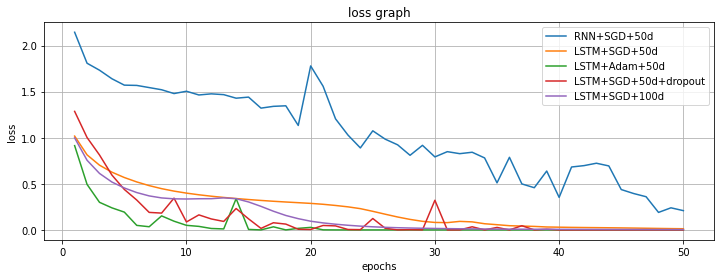

In [ ]:
plt.figure(figsize=(12, 4))
for model in models:
  plt.plot(range(1,51), model.loss_history)
plt.legend(model_names)
plt.title(f"loss graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid("on")
plt.show()

### 8.3 All emojis for test set

In [ ]:
model_predicts = [model.get_predict(X_r) for model in models]
predicts_to_emoji = np.array([[emo_utils.label_to_emoji(x) for x in predicts] for predicts in model_predicts+[Y_r]]).T
texts = [text.replace("\t","") for text in X_r]
predict_table = pd.DataFrame(predicts_to_emoji, index=texts, columns=model_names+["reference"])
predict_table

,RNN+SGD+50d,LSTM+SGD+50d,LSTM+Adam+50d,LSTM+SGD+50d+dropout,LSTM+SGD+100d,reference
I want to eat,🍴,🍴,🍴,🍴,🍴,🍴
he did not answer,😞,😞,😞,😞,😞,😞
he got a very nice raise,😄,😄,😞,😄,❤️,😄
she got me a nice present,😄,😄,😄,❤️,❤️,😄
ha ha ha it was so funny,😄,😄,😄,😄,😄,😄
he is a good friend,😄,😄,😞,😄,❤️,😄
I am upset,⚾,😞,😞,😞,😞,😞
We had such a lovely dinner tonight,⚾,😄,😄,😄,😄,😄
where is the food,🍴,🍴,🍴,🍴,🍴,🍴
Stop making this joke ha ha ha,😞,😄,😄,😄,😄,😄


## 9. Discussion

### 9.1 What is GloVe

GloVe was developed to overcome drawbacks of Word2Vec. The traditional embadding method, Word2Vec, does not concerned about co-occurrence. However, GloVe can not only get similiarity whitin two vectors, but also reflect occurrence of each word. Therefore, it can expect that GloVe does more accurate word embadding.